**Low-rank GEMM/GEMV:**

Given W ∈ R^{out×in}, truncated SVD with rank r:
    W ≈ U_r Σ_r V_r^T ≡ U_r (Σ_r V_r^T) =: U_r Ṽ_r^T

Forward y = W x turns into two small multiplies:
    y ≈ U_r (Ṽ_r^T x)

Cost (per sample, counting multiply-add as 1 op):
    dense GEMV  ~ out·in
    low-rank    ~ out·r + in·r

Break-even (benefit if):
    out·r + in·r < out·in  ⇒  r < (out·in)/(out+in)
    • For square n×n: r < n/2

Practical rank policy (kernel-friendly, stable):
    r ≤ min( α · break_even, β · min(in,out) )
    - α in [0.8..1.0],   β ≈ 0.30 (default here)
    - Align r to tensor-core multiples (64/128)
    - Favor smaller r for GEMV/small-batch; allow larger r for accuracy.

After conversion:
    • Do a brief KD/finetune to recover accuracy if needed.
    • You may export fused dense (u @ v) if your backend prefers a single GEMM.


In [146]:
# Cell 0 — Hardware inventory & device flag
import os, platform, subprocess, math, time
import torch

# User switch (auto-fallback to CPU if no CUDA)
USE_GPU = True

def list_cuda_devices():
    gpus = []
    if not torch.cuda.is_available():
        return gpus
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        gpus.append({
            "index": i,
            "name": props.name,
            "total_mem_GB": round(props.total_memory / (1024**3), 2),
            "cc": f"{props.major}.{props.minor}",
            "multi_processor_count": props.multi_processor_count
        })
    return gpus

def cpu_info():
    info = {
        "system": platform.system(),
        "release": platform.release(),
        "machine": platform.machine(),
        "python": platform.python_version(),
        "processor": platform.processor() or "N/A",
        "threads": os.cpu_count(),
    }
    try:
        import psutil
        v = psutil.virtual_memory()
        info["ram_GB"] = round(v.total / (1024**3), 2)
    except Exception:
        info["ram_GB"] = "unknown (install psutil for exact)"
    return info

gpus = list_cuda_devices()
cpu = cpu_info()

print("=== CPU ===")
for k,v in cpu.items(): print(f"{k:>12}: {v}")

print("\n=== GPUs ===")
if not gpus:
    print("No CUDA devices detected.")
else:
    for g in gpus:
        print(f"GPU {g['index']}: {g['name']} | {g['total_mem_GB']} GB | CC {g['cc']} | MPs {g['multi_processor_count']}")

if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("\nSelected device:", device)


=== CPU ===
      system: Windows
     release: 10
     machine: AMD64
      python: 3.10.18
   processor: AMD64 Family 25 Model 117 Stepping 2, AuthenticAMD
     threads: 16
      ram_GB: 27.75

=== GPUs ===
GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU | 6.0 GB | CC 8.9 | MPs 20

Selected device: cuda


In [147]:
import math, time, sys
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F


# Perf knobs (TF32 on Ampere+)
torch.set_float32_matmul_precision("high")
try:
    torch.backends.cuda.matmul.allow_tf32 = True
    print("Device (from Cell 0):", device, "| TF32:", torch.backends.cuda.matmul.allow_tf32)
except Exception:
    print("Device (from Cell 0):", device)
    pass




Device (from Cell 0): cuda | TF32: True


**Low-rank linear layer (UΣVᵀ as v⟶u)**

In [148]:
# Cell 2 — LowRankLinear (fixed from_dense & reconstruct_dense)
class LowRankLinear(nn.Module):
    """
    Factor dense W (out x in) into U (out x r) and V (r x in):
      v: in -> r  (weights = V * diag(S))
      u: r  -> out (weights = U)
    Forward computes y = u(v(x)) ~= U diag(S) V^T x.
    """
    def __init__(self, in_features, out_features, rank, bias=True):
        super().__init__()
        self.in_features = int(in_features)
        self.out_features = int(out_features)
        self.rank = int(rank)
        self.v = nn.Linear(self.in_features, self.rank, bias=False)   # (r, in)
        self.u = nn.Linear(self.rank, self.out_features, bias=bias)   # (out, r)

    def forward(self, x):
        return self.u(self.v(x))

    def reconstruct_dense(self) -> nn.Linear:
        """
        Fuse u and v back into one dense Linear:
          u.weight: (out, r), v.weight: (r, in)  ->  (out, in)
        """
        W_fused = (self.u.weight @ self.v.weight).contiguous()  # NOTE: no .T
        bias = self.u.bias
        dense = nn.Linear(self.in_features, self.out_features, bias=(bias is not None))
        with torch.no_grad():
            dense.weight.copy_(W_fused)
            if bias is not None:
                dense.bias.copy_(bias)
        return dense

    @staticmethod
    def _svd_topk(W: torch.Tensor, rank: int, randomized: bool=False, oversample: int=16):
        """
        Return top-k SVD of W (out x in): U_k (out x r), S_k (r,), Vt_k (r x in).
        Uses torch.svd_lowrank if randomized=True (if available); else exact SVD.
        """
        if randomized:
            try:
                q = min(rank + oversample, min(W.shape)-1)
                U, S, V = torch.svd_lowrank(W, q=q)
                U_k, S_k, V_k = U[:, :rank].contiguous(), S[:rank].contiguous(), V[:, :rank].contiguous()
                return U_k, S_k, V_k.T.contiguous()
            except Exception:
                pass
        U, S, Vt = torch.linalg.svd(W, full_matrices=False)
        return U[:, :rank].contiguous(), S[:rank].contiguous(), Vt[:rank, :].contiguous()

    @staticmethod
    def from_dense(dense_layer: nn.Linear, rank: int, randomized=False):
        """
        Convert nn.Linear to LowRankLinear with rank r.
        v.weight expects (r, in); u.weight expects (out, r).
        """
        W = dense_layer.weight.detach().clone()  # (out, in)
        U_r, S_r, Vt_r = LowRankLinear._svd_topk(W, rank, randomized=randomized)
        # Fold Σ into V: v(x) = (V Σ) x  -> V_scaled: (in, r).T -> (r, in)
        V_scaled = (Vt_r.T * S_r.unsqueeze(0)).contiguous()   # (in, r)
        lr = LowRankLinear(W.shape[1], W.shape[0], rank, bias=(dense_layer.bias is not None))
        with torch.no_grad():
            lr.v.weight.copy_(V_scaled.T)   # (r, in)
            lr.u.weight.copy_(U_r)          # (out, r)
            if dense_layer.bias is not None:
                lr.u.bias.copy_(dense_layer.bias)
        return lr


**Rank selection by energy (Eckart–Young) & FLOPs Helpers**

In [149]:
# Cell 3 — Rank Selection & FLOPs Helpers (updated)

@torch.no_grad()
def rank_from_energy(W: torch.Tensor, tau: float, multiple: int=None, r_max: int=None) -> int:
    S = torch.linalg.svdvals(W)
    energy = S * S
    cumsum = torch.cumsum(energy, dim=0)
    total = energy.sum()
    r = int(torch.searchsorted(cumsum, tau * total).item() + 1)
    if r_max is not None:
        r = min(r, int(r_max))
    if multiple is not None and multiple > 1:
        import math
        r = int(math.ceil(r / multiple) * multiple)
    return max(1, r)

def break_even_rank(in_features: int, out_features: int) -> int:
    # benefit when: in*r + r*out < in*out  =>  r < (in*out)/(in+out)
    return (in_features * out_features) // (in_features + out_features)

def rank_from_target_speedup(in_features: int,
                             out_features: int,
                             target_speedup: float,
                             multiple: int = 64,
                             max_frac_min_dim: float = 0.30,
                             alpha_break_even: float = 0.95) -> int:
    """
    Dense/low-rank speedup ≈ (in*out) / (r*(in+out)).
    For a desired speedup S => r ≈ (in*out) / (S*(in+out)) = break_even / S.
    Then cap by policy and align to `multiple`.
    """
    import math
    r_be = break_even_rank(in_features, out_features)
    r = max(1, int(r_be / max(target_speedup, 1e-6)))

    # Caps: ≤ α·break_even and ≤ β·min(in,out)
    r_cap_be  = int(alpha_break_even * r_be)
    r_cap_min = int(max_frac_min_dim * min(in_features, out_features))
    r = min(r, r_cap_be, r_cap_min)

    # Align to kernel-friendly multiple
    r = int(math.ceil(r / multiple) * multiple)
    r = min(r, min(in_features, out_features) - 1)
    return max(1, r)

def flops_gemv(out_features, in_features, batch=1):
    return int(out_features * in_features * batch)

def flops_lowrank_gemv(out_features, in_features, rank, batch=1):
    return int(batch * (in_features*rank + rank*out_features))


**Micro-benchmark Utility (median / p90 / mean)**

In [150]:
# Cell 4 — Micro-benchmark Utility
@torch.inference_mode()
def bench_layer(layer: nn.Module, x: torch.Tensor, iters: int = 120, warmup: int = 40):
    layer.eval()
    if torch.cuda.is_available(): torch.cuda.synchronize()
    for _ in range(warmup):
        _ = layer(x)
    if torch.cuda.is_available(): torch.cuda.synchronize()
    ts = []
    for _ in range(iters):
        t0 = time.perf_counter()
        _ = layer(x)
        if torch.cuda.is_available(): torch.cuda.synchronize()
        ts.append(time.perf_counter() - t0)
    arr = np.array(ts, dtype=np.float64)
    return float(np.median(arr)), float(np.percentile(arr, 90)), float(np.mean(arr))


**Minimal Dense Layer & Inputs**

In [151]:
# Cell 5 — Minimal Dense Layer & Inputs
class SingleLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features, bias=bias)
        nn.init.normal_(self.fc.weight, mean=0.0, std=0.02)
        if bias: nn.init.zeros_(self.fc.bias)
    def forward(self, x):
        return self.fc(x)

# Example shape: transformer-like projection
in_features  = 4096
out_features = 4096
batch_gemm   = 256

torch.manual_seed(0)
dense_layer = SingleLinear(in_features, out_features).to(device).fc
x_gemv = torch.randn(1, in_features, device=device)
x_gemm = torch.randn(batch_gemm, in_features, device=device)

print("Dense W:", tuple(dense_layer.weight.shape))
print("Dense b:", tuple(dense_layer.bias.shape) if dense_layer.bias is not None else "None")

Dense W: (4096, 4096)
Dense b: (4096,)


**Choose Rank (Energy or Target-speedup)**

In [152]:
# Cell 6 — Choose Rank (Energy or Target-speedup) with rank caps (updated)

tau = 0.95
rank_multiple = 64

# --- New knobs ---
AUTO_MODE = "target"     # "target" or "energy"
TARGET_SPEEDUP = 1.8     # used if AUTO_MODE == "target"
MAX_FRAC_MIN_DIM = 0.30  # ≤ 30% of min(in,out)
ALPHA_BE = 0.95          # ≤ 95% of break-even

# Pick rank
if AUTO_MODE == "target":
    rank = rank_from_target_speedup(
        in_features, out_features,
        target_speedup=TARGET_SPEEDUP,
        multiple=rank_multiple,
        max_frac_min_dim=MAX_FRAC_MIN_DIM,
        alpha_break_even=ALPHA_BE,
    )
else:
    # Energy rule + caps
    rank = rank_from_energy(
        dense_layer.weight.detach().cpu(),
        tau=tau, multiple=rank_multiple,
        r_max=min(in_features, out_features)
    )
    # Apply the same policy caps
    r_be = break_even_rank(in_features, out_features)
    r_cap_be  = int(ALPHA_BE * r_be)
    r_cap_min = int(MAX_FRAC_MIN_DIM * min(in_features, out_features))
    r_cap = max(1, min(r_cap_be, r_cap_min))
    import math
    rank = min(rank, r_cap)
    rank = int(math.ceil(rank / rank_multiple) * rank_multiple)
    rank = min(rank, min(in_features, out_features) - 1)

r_be = break_even_rank(in_features, out_features)
print(f"Chosen rank: {rank} | Break-even rank: {r_be} (benefit if r < {r_be})")
print(f"Policy: α·BE={int(ALPHA_BE*r_be)}, β·min={int(MAX_FRAC_MIN_DIM*min(in_features,out_features))}, multiple={rank_multiple}")
if rank >= r_be:
    print("WARNING: rank ≥ break-even → likely slower than dense.")


Chosen rank: 1152 | Break-even rank: 2048 (benefit if r < 2048)
Policy: α·BE=1945, β·min=1228, multiple=64


**Convert to Low-Rank & Sanity-Check Shapes**

In [153]:
# Cell 7 — Convert to Low-Rank & Sanity-Check (updated randomized SVD policy)

def use_randomized_svd(in_features: int, out_features: int) -> bool:
    # Heuristic: use randomized when matrices are large
    return min(in_features, out_features) >= 2048

rnd = use_randomized_svd(in_features, out_features)
lowrank_layer = LowRankLinear.from_dense(dense_layer, rank=rank, randomized=rnd).to(device)

assert lowrank_layer.u.weight.shape == (out_features, rank), lowrank_layer.u.weight.shape
assert lowrank_layer.v.weight.shape == (rank, in_features), lowrank_layer.v.weight.shape
print(f"Shapes OK: u {tuple(lowrank_layer.u.weight.shape)}  v {tuple(lowrank_layer.v.weight.shape)} | randomized_svd={rnd}")


Shapes OK: u (4096, 1152)  v (1152, 4096) | randomized_svd=True


**Correctness, Theoretical FLOPs, and Latency**

In [154]:
# Cell 8 — Correctness, FLOPs, and Latency
with torch.inference_mode():
    y_dense = dense_layer(x_gemm)
    y_low   = lowrank_layer(x_gemm)
    rel_err = (y_dense - y_low).norm() / (y_dense.norm() + 1e-12)
print(f"Relative error (batch={batch_gemm}): {rel_err.item():.3e}")

# FLOPs (per forward)
flops_dense_v = flops_gemv(out_features, in_features, batch=1)
flops_low_v   = flops_lowrank_gemv(out_features, in_features, rank, batch=1)
flops_dense_m = flops_gemv(out_features, in_features, batch=batch_gemm)
flops_low_m   = flops_lowrank_gemv(out_features, in_features, rank, batch=batch_gemm)

print("\nTheoretical FLOPs:")
print(f"  GEMV  dense: {flops_dense_v:,} | low-rank: {flops_low_v:,} | reduction: {flops_dense_v/max(flops_low_v,1):,.2f}×")
print(f"  GEMM  dense: {flops_dense_m:,} | low-rank: {flops_low_m:,} | reduction: {flops_dense_m/max(flops_low_m,1):,.2f}×")

# Latency
med_v, p90_v, mean_v = bench_layer(dense_layer, x_gemv, iters=120, warmup=40)
med_v_lr, p90_v_lr, mean_v_lr = bench_layer(lowrank_layer, x_gemv, iters=120, warmup=40)

med_m, p90_m, mean_m = bench_layer(dense_layer, x_gemm, iters=120, warmup=40)
med_m_lr, p90_m_lr, mean_m_lr = bench_layer(lowrank_layer, x_gemm, iters=120, warmup=40)

print("\nLatency (seconds) — median / p90 / mean")
print(f"  GEMV dense:    {med_v:.6f} / {p90_v:.6f} / {mean_v:.6f}")
print(f"  GEMV low-rank: {med_v_lr:.6f} / {p90_v_lr:.6f} / {mean_v_lr:.6f} | speedup: {med_v/max(med_v_lr,1e-12):.2f}×")

print(f"  GEMM dense:    {med_m:.6f} / {p90_m:.6f} / {mean_m:.6f}")
print(f"  GEMM low-rank: {med_m_lr:.6f} / {p90_m_lr:.6f} / {mean_m_lr:.6f} | speedup: {med_m/max(med_m_lr,1e-12):.2f}×")


Relative error (batch=256): 5.961e-01

Theoretical FLOPs:
  GEMV  dense: 16,777,216 | low-rank: 9,437,184 | reduction: 1.78×
  GEMM  dense: 4,294,967,296 | low-rank: 2,415,919,104 | reduction: 1.78×

Latency (seconds) — median / p90 / mean
  GEMV dense:    0.000456 / 0.000491 / 0.000463
  GEMV low-rank: 0.000279 / 0.000337 / 0.000289 | speedup: 1.63×
  GEMM dense:    0.001006 / 0.001098 / 0.001023
  GEMM low-rank: 0.000546 / 0.000611 / 0.000563 | speedup: 1.84×


**Params & Fused Export Parity**

In [155]:
# Cell 9 — Params & Fused Export Parity
def count_params_linear(m: nn.Linear) -> int:
    p = m.weight.numel()
    if m.bias is not None: p += m.bias.numel()
    return int(p)

dense_params = count_params_linear(dense_layer)
low_params   = count_params_linear(lowrank_layer.v) + count_params_linear(lowrank_layer.u)
print("\nParameters (float32 count proxy):")
print(f"  dense:    {dense_params:,}")
print(f"  low-rank: {low_params:,} | reduction: {dense_params/max(low_params,1):,.2f}×")

# Correct fusion: (out, r) @ (r, in) -> (out, in)
fused = lowrank_layer.reconstruct_dense().to(device)
with torch.inference_mode():
    diff_export = (fused(x_gemm) - lowrank_layer(x_gemm)).abs().max().item()
print(f"Fused-dense export parity (max-abs diff): {diff_export:.3e}")



Parameters (float32 count proxy):
  dense:    16,781,312
  low-rank: 9,441,280 | reduction: 1.78×
Fused-dense export parity (max-abs diff): 1.462e-03


**Force Practical Rank (256/512) & Re-benchmark (Optional)**

In [156]:
# Cell 10 — Force Practical Rank (256/512) & Re-benchmark (Optional)
forced_rank = 256  # try 256 or 512 for 4096×4096
print(f"Forcing rank to: {forced_rank}")
lowrank_layer = LowRankLinear.from_dense(dense_layer, rank=forced_rank, randomized=False).to(device)

with torch.inference_mode():
    y_dense = dense_layer(x_gemm)
    y_low   = lowrank_layer(x_gemm)
    rel_err = (y_dense - y_low).norm() / (y_dense.norm() + 1e-12)
print(f"Relative error (forced r={forced_rank}): {rel_err.item():.3e}")

med_m, _, _    = bench_layer(dense_layer, x_gemm, iters=120, warmup=40)
med_m_lr, _, _ = bench_layer(lowrank_layer, x_gemm, iters=120, warmup=40)
print(f"GEMM speedup (forced r={forced_rank}): {med_m/max(med_m_lr,1e-12):.2f}×")


Forcing rank to: 256
Relative error (forced r=256): 8.888e-01
GEMM speedup (forced r=256): 4.43×


**MNIST Data (with fallback)**

In [157]:
# Cell 11 — MNIST Data (with fallback if torchvision not present)
try:
    import torchvision
    from torchvision import datasets, transforms
    have_tv = True
except Exception as e:
    have_tv = False
    print("torchvision not available; you can install it to run MNIST demo.")

BATCH = 256
if have_tv:
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
    test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)


**Large MLP for MNIST**

In [158]:
# Cell 12 — Large MLP (big Linear dims to stress GEMM/GEMV)
class MNISTBigMLP(nn.Module):
    def __init__(self, hidden=4096):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, hidden)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden, 10)
    def forward(self, x):
        x = self.flatten(x)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x

model = MNISTBigMLP(hidden=4096).to(device)
print(model)


MNISTBigMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=4096, bias=True)
  (act): GELU(approximate='none')
  (fc2): Linear(in_features=4096, out_features=10, bias=True)
)


**MNIST Quick Train (few steps)**

In [159]:
# Cell 13 — MNIST Quick Train (few steps just to get non-trivial weights)
if have_tv:
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    steps = 300  # keep light; adjust as needed
    model.train()
    it = iter(train_loader)
    for s in range(steps):
        try:
            xb, yb = next(it)
        except StopIteration:
            it = iter(train_loader)
            xb, yb = next(it)
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()
        if (s+1) % 50 == 0:
            print(f"Step {s+1}/{steps} | loss={loss.item():.3f}")


Step 50/300 | loss=0.246
Step 100/300 | loss=0.183
Step 150/300 | loss=0.128
Step 200/300 | loss=0.094
Step 250/300 | loss=0.105
Step 300/300 | loss=0.068


**Eval & Convert fc1 with Low-Rank**

In [160]:
# Cell 14 — Eval & Convert fc1 with Low-Rank
def eval_mnist(model, loader):
    model.eval()
    correct = total = 0
    with torch.inference_mode():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            pred = logits.argmax(dim=1)
            correct += int((pred == yb).sum().item())
            total   += int(yb.numel())
    return correct / max(total,1)

if have_tv:
    acc_before = eval_mnist(model, test_loader)
    print(f"MNIST test accuracy (before): {acc_before:.3f}")

# Convert fc1 (4096 x 784) to low-rank
target_r = 512  # good starting point
print(f"Converting fc1 to LowRankLinear with rank={target_r}")
model.fc1 = LowRankLinear.from_dense(model.fc1, rank=target_r, randomized=False).to(device)

if have_tv:
    acc_after = eval_mnist(model, test_loader)
    print(f"MNIST test accuracy (after):  {acc_after:.3f}")

# Quick forward speed
xb = torch.randn(1024, 1, 28, 28, device=device)
t0 = time.perf_counter(); _ = model(xb); 
if torch.cuda.is_available(): torch.cuda.synchronize()
print(f"Forward latency (1024 imgs, post-conv): {(time.perf_counter()-t0):.4f}s")


MNIST test accuracy (before): 0.974
Converting fc1 to LowRankLinear with rank=512
MNIST test accuracy (after):  0.975
Forward latency (1024 imgs, post-conv): 0.0114s


**Load a Model & Tokenizer (DistilBERT example)**

In [161]:
# Cell 15 — Load a Model & Tokenizer (DistilBERT)
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    have_hf = True
except Exception:
    have_hf = False
    print("transformers not available; install to run BERT/Transformer patches.")

MODEL_NAME = "distilbert-base-uncased"
NUM_LABELS = 2

if have_hf:
    tok = AutoTokenizer.from_pretrained(MODEL_NAME)
    model_hf = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(device)
    model_hf.eval()
    print("Loaded:", MODEL_NAME)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded: distilbert-base-uncased


**Patch Utility: selective Low-Rank conversion**

In [162]:
# Cell 16 — Patch Utility (strong device/dtype safety + skip non-beneficial ranks)
from dataclasses import dataclass

@dataclass
class PatchSpec:
    tau: float | None = None      # if None => use fixed rank
    rank: int = 256               # used when tau is None
    multiple: int = 64            # align rank to this multiple
    randomized: bool = False
    min_in: int = 256
    min_out: int = 256
    patch_attention: bool = True
    patch_ffn: bool = True

def _aligned_rank(r: int, multiple: int) -> int:
    import math
    return int(math.ceil(max(1, r) / multiple) * multiple)

def _should_patch_linear(name: str, mod: nn.Module, spec: PatchSpec):
    if not isinstance(mod, nn.Linear): return False
    if mod.in_features < spec.min_in or mod.out_features < spec.min_out: return False
    lname = name.lower()
    attn_keys = ["q_lin", "k_lin", "v_lin", "out_lin", "attention"]
    ffn_keys  = ["ffn", "intermediate", "lin1", "lin2", "dense"]
    if spec.patch_attention and any(k in lname for k in attn_keys): return True
    if spec.patch_ffn and any(k in lname for k in ffn_keys): return True
    return False

def _pick_rank(layer: nn.Linear, spec: PatchSpec):
    import math, torch
    r_max = min(layer.in_features, layer.out_features)
    if spec.tau is not None:
        r = rank_from_energy(layer.weight.detach().cpu(), tau=spec.tau,
                             multiple=spec.multiple, r_max=r_max)
    else:
        r = min(spec.rank, r_max)
        r = _aligned_rank(r, spec.multiple)
        r = min(r, r_max-1)
    return max(1, r)

def _move_like(ref: nn.Linear, lr: LowRankLinear):
    # Force exact device/dtype as the reference Linear's weights (safest)
    dev = ref.weight.device
    dt  = ref.weight.dtype
    lr.v.to(device=dev, dtype=dt)
    lr.u.to(device=dev, dtype=dt)
    # Also ensure the container is on device/dtype (not strictly required, but tidy)
    lr.to(device=dev, dtype=dt)
    # Sanity
    assert lr.v.weight.device == dev and lr.u.weight.device == dev
    assert lr.v.weight.dtype  == dt  and lr.u.weight.dtype  == dt
    return lr

def patch_model_lowrank(model: nn.Module, spec: PatchSpec):
    """
    Replace selected nn.Linear with LowRankLinear:
      - skip if rank >= break-even (no expected speed gain)
      - ensure new module matches original device/dtype exactly
    """
    replaced = []
    for name, mod in list(model.named_modules()):
        if not _should_patch_linear(name, mod, spec):
            continue

        # Walk to parent to replace attribute safely
        parent = model
        *parents, child = name.split(".")
        for p in parents:
            parent = getattr(parent, p)
        old = getattr(parent, child)
        if not isinstance(old, nn.Linear):
            continue

        r = _pick_rank(old, spec)
        r_be = break_even_rank(old.in_features, old.out_features)
        if r >= r_be:
            continue  # skip non-beneficial ranks

        # Build low-rank on CPU (SVD), then hard-move to old's device/dtype
        lr = LowRankLinear.from_dense(old, rank=r, randomized=spec.randomized)
        lr = _move_like(old, lr)

        setattr(parent, child, lr)
        replaced.append((name, old.in_features, old.out_features, r,
                         str(old.weight.device), str(old.weight.dtype)))
    return replaced


**DistilBERT: Patch, Forward, Speed, Error**

In [163]:
# Cell 17 — DistilBERT: Patch FFN first, then FFN+Attn (device-safe)
if have_hf:
    texts = ["this movie was great!", "the plot was dull but acting decent.", "absolutely terrible"] * 16
    batch = tok(texts, padding=True, truncation=True, return_tensors="pt").to(device)

    # Make sure model is on the target device/dtype BEFORE we measure baseline
    model_hf.to(device)
    model_hf.eval()

    # Baseline outputs & latency
    with torch.inference_mode():
        t0 = time.perf_counter()
        out_base = model_hf(**batch).logits
        if torch.cuda.is_available(): torch.cuda.synchronize()
        t_base = time.perf_counter() - t0

    # 1) Patch FFN only
    spec_ffn = PatchSpec(tau=None, rank=256, multiple=64, randomized=False,
                         min_in=256, min_out=256, patch_attention=False, patch_ffn=True)
    replaced_ffn = patch_model_lowrank(model_hf, spec_ffn)
    # Force the whole model back to device/dtype (belt & suspenders)
    model_hf.to(device)
    print("FFN replacements:")
    for r in replaced_ffn[:12]:
        print("  ", r)
    if len(replaced_ffn) > 12:
        print(f"  ... (+{len(replaced_ffn)-12} more)")

    # Sanity: confirm v/u are on CUDA (or target device)
    bad = []
    for n, m in model_hf.named_modules():
        if isinstance(m, LowRankLinear):
            if str(m.v.weight.device) != str(device) or str(m.u.weight.device) != str(device):
                bad.append((n, str(m.v.weight.device), str(m.u.weight.device)))
    if bad:
        print("Device mismatch after FFN patch:", bad)

    with torch.inference_mode():
        t0 = time.perf_counter()
        out_ffn = model_hf(**batch).logits
        if torch.cuda.is_available(): torch.cuda.synchronize()
        t_ffn = time.perf_counter() - t0
    rel_err_ffn = (out_base - out_ffn).norm() / (out_base.norm() + 1e-12)
    print(f"\nFFN-only: baseline={t_base:.4f}s | low-rank={t_ffn:.4f}s | speedup={(t_base/max(t_ffn,1e-12)):.2f}× | rel_err={rel_err_ffn.item():.3e}")

    # 2) Patch attention too (fresh model to avoid double-patching)
    model_hf = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(device)
    model_hf.eval()
    with torch.inference_mode():
        out_base2 = model_hf(**batch).logits

    spec_all = PatchSpec(tau=None, rank=256, multiple=64, randomized=False,
                         min_in=256, min_out=256, patch_attention=True, patch_ffn=True)
    replaced_all = patch_model_lowrank(model_hf, spec_all)
    model_hf.to(device)  # force everything to device again
    print("\nFFN + Attention replacements:")
    for r in replaced_all[:12]:
        print("  ", r)
    if len(replaced_all) > 12:
        print(f"  ... (+{len(replaced_all)-12} more)")

    bad2 = []
    for n, m in model_hf.named_modules():
        if isinstance(m, LowRankLinear):
            if str(m.v.weight.device) != str(device) or str(m.u.weight.device) != str(device):
                bad2.append((n, str(m.v.weight.device), str(m.u.weight.device)))
    if bad2:
        print("Device mismatch after ALL patch:", bad2)

    with torch.inference_mode():
        t0 = time.perf_counter()
        out_low = model_hf(**batch).logits
        if torch.cuda.is_available(): torch.cuda.synchronize()
        t_low = time.perf_counter() - t0
    rel_err_all = (out_base2 - out_low).norm() / (out_base2.norm() + 1e-12)
    print(f"\nFFN+Attn: baseline={t_base:.4f}s | low-rank={t_low:.4f}s | speedup={(t_base/max(t_low,1e-12)):.2f}× | rel_err={rel_err_all.item():.3e}")


FFN replacements:
   ('distilbert.transformer.layer.0.ffn.lin1', 768, 3072, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.0.ffn.lin2', 3072, 768, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.1.ffn.lin1', 768, 3072, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.1.ffn.lin2', 3072, 768, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.2.ffn.lin1', 768, 3072, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.2.ffn.lin2', 3072, 768, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.3.ffn.lin1', 768, 3072, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.3.ffn.lin2', 3072, 768, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.4.ffn.lin1', 768, 3072, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.4.ffn.lin2', 3072, 768, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.5.ffn.lin1', 768, 3072, 256, 'cuda:0', 'torch.fl

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



FFN + Attention replacements:
   ('distilbert.transformer.layer.0.attention.q_lin', 768, 768, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.0.attention.k_lin', 768, 768, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.0.attention.v_lin', 768, 768, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.0.attention.out_lin', 768, 768, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.0.ffn.lin1', 768, 3072, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.0.ffn.lin2', 3072, 768, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.1.attention.q_lin', 768, 768, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.1.attention.k_lin', 768, 768, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.1.attention.v_lin', 768, 768, 256, 'cuda:0', 'torch.float32')
   ('distilbert.transformer.layer.1.attention.out_lin', 768, 768, 256, 'cuda:0', 'torch.float32')
   ('distilbert.t

**Rank Sweep Utility (Compact)**

In [164]:
# Cell 18 — Rank Sweep Utility (Compact; for your dense test layer)
def rank_sweep_report(dense_layer: nn.Linear, x_gemv, x_gemm, ranks):
    print(f"{'r':>6}  {'rel_err':>10}  {'GEMV_spd×':>9}  {'GEMM_spd×':>9}  "
          f"{'GEMV FLOPs d→lr':>18}  {'GEMM FLOPs d→lr':>20}")
    print("-"*80)
    with torch.inference_mode():
        y_dense_ref = dense_layer(x_gemm)
    for r in ranks:
        lr = LowRankLinear.from_dense(dense_layer, rank=r, randomized=False).to(device)
        with torch.inference_mode():
            y_lr = lr(x_gemm)
            rel_err = (y_dense_ref - y_lr).norm() / (y_dense_ref.norm() + 1e-12)
        fl_v_d = out_features*in_features
        fl_v_l = in_features*r + r*out_features
        fl_m_d = fl_v_d * batch_gemm
        fl_m_l = fl_v_l * batch_gemm
        med_v,_,_    = bench_layer(dense_layer, x_gemv, iters=80, warmup=30)
        med_v_lr,_,_ = bench_layer(lr,          x_gemv, iters=80, warmup=30)
        med_m,_,_    = bench_layer(dense_layer, x_gemm, iters=80, warmup=30)
        med_m_lr,_,_ = bench_layer(lr,          x_gemm, iters=80, warmup=30)
        print(f"{r:6d}  {float(rel_err):10.3e}  {med_v/max(med_v_lr,1e-12):9.2f}  {med_m/max(med_m_lr,1e-12):9.2f}  "
              f"{fl_v_d:9,d}→{fl_v_l:9,d}  {fl_m_d:11,d}→{fl_m_l:11,d}")

# Example sweep (adjust as you like)
ranks = [128, 192, 256, 384, 512, 768, 1024]
rank_sweep_report(dense_layer, x_gemv, x_gemm, ranks)


     r     rel_err  GEMV_spd×  GEMM_spd×     GEMV FLOPs d→lr       GEMM FLOPs d→lr
--------------------------------------------------------------------------------
   128   9.421e-01       5.13       5.61  16,777,216→1,048,576  4,294,967,296→268,435,456
   192   9.150e-01       5.77       3.85  16,777,216→1,572,864  4,294,967,296→402,653,184
   256   8.888e-01       6.44       4.95  16,777,216→2,097,152  4,294,967,296→536,870,912
   384   8.380e-01       4.30       4.85  16,777,216→3,145,728  4,294,967,296→805,306,368
   512   7.892e-01       3.13       2.52  16,777,216→4,194,304  4,294,967,296→1,073,741,824
   768   6.995e-01       2.44       2.21  16,777,216→6,291,456  4,294,967,296→1,610,612,736
  1024   6.143e-01       1.89       1.87  16,777,216→8,388,608  4,294,967,296→2,147,483,648


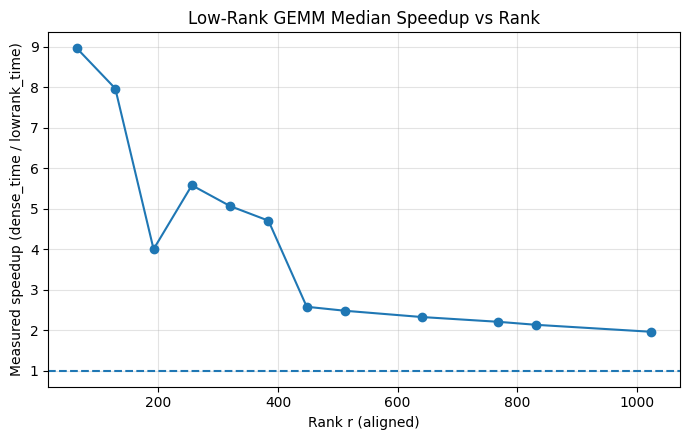

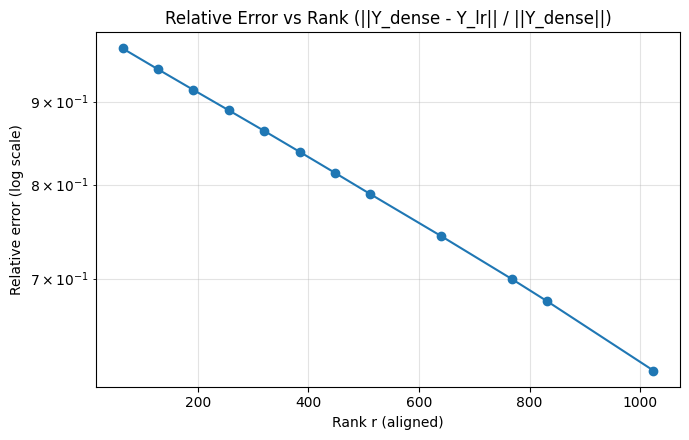

     r   speedup×     rel_err  theo(d/l)×
------------------------------------------
    64       8.95   9.704e-01       32.00
   128       7.96   9.421e-01       16.00
   192       4.00   9.150e-01       10.67
   256       5.58   8.888e-01        8.00
   320       5.06   8.633e-01        6.40
   384       4.70   8.380e-01        5.33
   448       2.58   8.134e-01        4.57
   512       2.48   7.892e-01        4.00
   640       2.32   7.436e-01        3.20
   768       2.21   6.995e-01        2.67
   832       2.13   6.778e-01        2.46
  1024       1.96   6.143e-01        2.00


In [165]:
# Final Cell — Rank sweep + charts (speedup & error)
import matplotlib.pyplot as plt

# 1) Build candidate ranks (aligned, under policy)
def aligned(r, m=rank_multiple): return int(math.ceil(r / m) * m)
nmin = min(in_features, out_features)
cands = [64, 96, 128, 160, 192, 224, 256, 320, 384, 512, 640, 768, 1024]
cands = [aligned(r) for r in cands if r < nmin]
# Also include fractions of min dim under 0.30 cap
fractions = [0.05, 0.075, 0.10, 0.125, 0.15, 0.20, 0.25, 0.30]
cands += [aligned(int(fr * nmin)) for fr in fractions]
# Dedup + keep under caps and under break-even
cands = sorted(set([r for r in cands if r < nmin and r < break_even_rank(in_features, out_features)
                    and r <= int(MAX_FRAC_MIN_DIM * nmin)]))

# 2) Baseline reference outputs (GEMM)
with torch.inference_mode():
    y_ref = dense_layer(x_gemm)

# 3) Sweep
records = []
for r in cands:
    lr = LowRankLinear.from_dense(dense_layer, rank=r, randomized=False).to(device)

    # Error
    with torch.inference_mode():
        y_lr = lr(x_gemm)
        rel_err = (y_ref - y_lr).norm() / (y_ref.norm() + 1e-12)
        rel_err = float(rel_err)

    # Latency (GEMM median)
    med_dense, _, _ = bench_layer(dense_layer, x_gemm, iters=80, warmup=30)
    med_lr,    _, _ = bench_layer(lr,          x_gemm, iters=80, warmup=30)
    spd = med_dense / max(med_lr, 1e-12)

    # Theoretical GEMM flops ratio (dense / lowrank)
    fl_d = in_features * out_features * batch_gemm
    fl_l = (in_features*r + r*out_features) * batch_gemm
    theo = fl_d / max(fl_l, 1)

    records.append((r, spd, rel_err, theo))

# 4) Prepare arrays
ranks = np.array([t[0] for t in records], dtype=np.int32)
speed = np.array([t[1] for t in records], dtype=np.float64)
err   = np.array([t[2] for t in records], dtype=np.float64)
theoR = np.array([t[3] for t in records], dtype=np.float64)

# 5) Chart 1 — GEMM speedup vs rank
plt.figure(figsize=(7,4.5))
plt.plot(ranks, speed, marker='o')
plt.axhline(1.0, linestyle='--')
plt.title("Low-Rank GEMM Median Speedup vs Rank")
plt.xlabel("Rank r (aligned)")
plt.ylabel("Measured speedup (dense_time / lowrank_time)")
plt.grid(True, which='both', alpha=0.35)
plt.tight_layout()
plt.show()

# 6) Chart 2 — Relative error vs rank (log y-scale)
plt.figure(figsize=(7,4.5))
plt.plot(ranks, err, marker='o')
plt.yscale("log")
plt.title("Relative Error vs Rank (||Y_dense - Y_lr|| / ||Y_dense||)")
plt.xlabel("Rank r (aligned)")
plt.ylabel("Relative error (log scale)")
plt.grid(True, which='both', alpha=0.35)
plt.tight_layout()
plt.show()

# 7) (Optional) print a compact table including theoretical ratio
print(f"{'r':>6}  {'speedup×':>9}  {'rel_err':>10}  {'theo(d/l)×':>10}")
print("-"*42)
for r, s, e, t in records:
    print(f"{r:6d}  {s:9.2f}  {e:10.3e}  {t:10.2f}")


**Prepare teacher & student (fresh), tokenizer, and data**

In [166]:
# Cell 21 — Prepare teacher (baseline) & student (low-rank), tokenizer, and batch
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    have_hf = True
except Exception:
    have_hf = False
    print("transformers not available; install to run BERT KD demo.")

MODEL_NAME = "distilbert-base-uncased"
NUM_LABELS = 2

if have_hf:
    tok = AutoTokenizer.from_pretrained(MODEL_NAME)
    teacher = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(device).eval()

    # Build a new student and patch it using your patch utility (Cell 16)
    student = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(device)
    student.eval()

    # Choose rank policy for patching (FFN+Attention or FFN-only)
    spec = PatchSpec(tau=None, rank=256, multiple=64, randomized=False,
                     min_in=256, min_out=256, patch_attention=True, patch_ffn=True)
    replaced = patch_model_lowrank(student, spec)
    student.to(device)
    print(f"Patched modules: {len(replaced)}")

    # Toy dataset (you can replace with a real loader)
    texts = [
        "this movie was great!", "the plot was dull but acting decent.",
        "absolutely terrible", "wonderfully acted and surprisingly moving.",
        "boring and overlong", "a charming, witty script"
    ] * 64  # ~384 samples
    enc = tok(texts, padding=True, truncation=True, return_tensors="pt")
    labels = torch.randint(0, NUM_LABELS, (enc["input_ids"].shape[0],))
    for k in enc: enc[k] = enc[k].to(device)
    labels = labels.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Patched modules: 36


**KD/finetune loop**

step 50/300  loss=0.0806
step 100/300  loss=0.0688
step 150/300  loss=0.0680
step 200/300  loss=0.0713
step 250/300  loss=0.0697
step 300/300  loss=0.0666


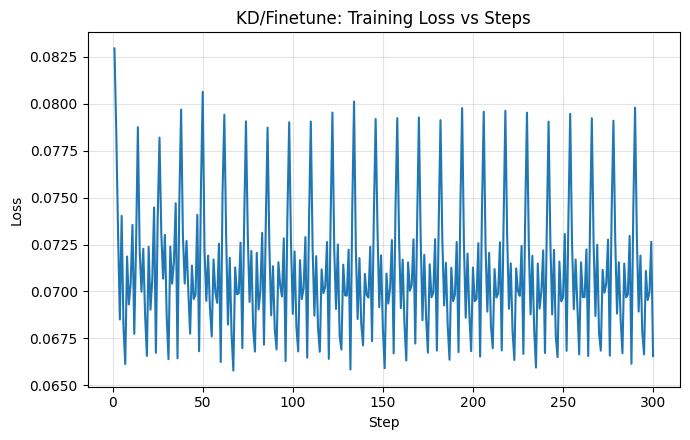

In [167]:
# Cell 22 — Tiny KD/finetune loop for the student
import math
import matplotlib.pyplot as plt

if have_hf:
    student.train()
    teacher.eval()
    opt = torch.optim.AdamW(student.parameters(), lr=5e-5, weight_decay=0.0)
    T = 2.0  # temperature for KD
    alpha = 0.9  # weight on KD loss (vs hard labels)
    steps = 300  # small demo; raise for better parity

    # Precompute teacher logits (no grad)
    with torch.inference_mode():
        tlogits = teacher(**enc).logits

    losses = []
    bs = 32
    for s in range(steps):
        i0 = (s * bs) % enc["input_ids"].shape[0]
        i1 = i0 + bs
        batch = {k: v[i0:i1] for k,v in enc.items()}
        yb = labels[i0:i1]
        with torch.no_grad():
            tlog_b = tlogits[i0:i1]

        out = student(**batch).logits
        # KD loss (KL divergence of soft targets)
        log_p = torch.log_softmax(out / T, dim=-1)
        p_t   = torch.softmax(tlog_b / T, dim=-1)
        kd = torch.nn.functional.kl_div(log_p, p_t, reduction="batchmean") * (T*T)
        # Hard label CE (optional)
        ce = torch.nn.functional.cross_entropy(out, yb)
        loss = alpha * kd + (1.0 - alpha) * ce

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        losses.append(loss.item())

        if (s+1) % 50 == 0:
            print(f"step {s+1}/{steps}  loss={loss.item():.4f}")

    student.eval()

    # Chart KD loss
    plt.figure(figsize=(7,4.5))
    plt.plot(range(1, steps+1), losses)
    plt.title("KD/Finetune: Training Loss vs Steps")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid(True, which='both', alpha=0.35)
    plt.tight_layout()
    plt.show()


**Measure latency & error, and plot comparison**

Latency — teacher: 0.0630s | student (low-rank+KD): 0.0418s | speedup: 1.51×
Relative logits error: 2.843e-01
Params — teacher: 66,955,010 | student: 45,721,346 | reduction: 1.46×


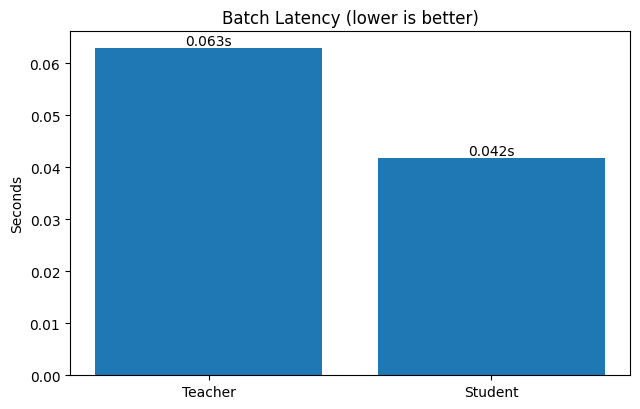

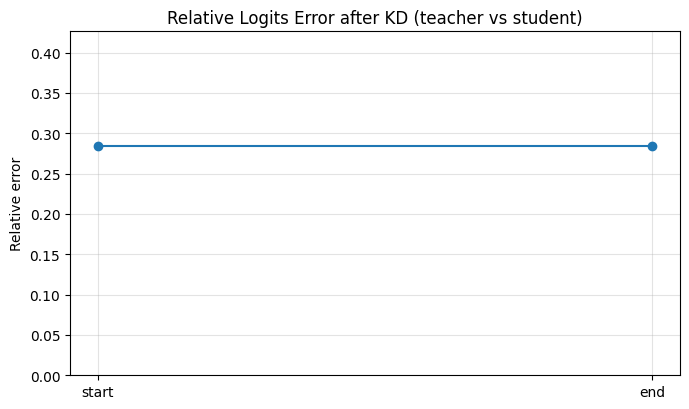


Summary -> speedup: 1.51× | rel_err: 2.843e-01 | params: 66,955,010 → 45,721,346


In [168]:
# Cell 23 — Measure latency & error, and plot comparison
import matplotlib.pyplot as plt
import numpy as np

if have_hf:
    # Latency (same batch enc)
    with torch.inference_mode():
        t0 = time.perf_counter()
        out_teacher = teacher(**enc).logits
        if torch.cuda.is_available(): torch.cuda.synchronize()
        t_teacher = time.perf_counter() - t0

    with torch.inference_mode():
        t0 = time.perf_counter()
        out_student = student(**enc).logits
        if torch.cuda.is_available(): torch.cuda.synchronize()
        t_student = time.perf_counter() - t0

    # Relative error
    rel_err = (out_teacher - out_student).norm() / (out_teacher.norm() + 1e-12)
    rel_err = float(rel_err)

    # Params count (rough proxy)
    def count_params(m):
        return sum(p.numel() for p in m.parameters())

    p_teacher = count_params(teacher)
    p_student = count_params(student)

    # Print summary
    print(f"Latency — teacher: {t_teacher:.4f}s | student (low-rank+KD): {t_student:.4f}s | speedup: {t_teacher/max(t_student,1e-12):.2f}×")
    print(f"Relative logits error: {rel_err:.3e}")
    print(f"Params — teacher: {p_teacher:,} | student: {p_student:,} | reduction: {p_teacher/max(p_student,1):.2f}×")

    # Chart 1: latency bars
    plt.figure(figsize=(6.5,4.2))
    names = ["Teacher", "Student"]
    times = [t_teacher, t_student]
    plt.bar(names, times)
    plt.title("Batch Latency (lower is better)")
    plt.ylabel("Seconds")
    for i, v in enumerate(times): plt.text(i, v, f"{v:.3f}s", ha="center", va="bottom")
    plt.tight_layout()
    plt.show()

    # Chart 2: relative error + param reduction (dual view)
    fig, ax1 = plt.subplots(figsize=(7,4.2))
    ax1.plot([0,1], [rel_err, rel_err], marker='o')  # flat line to show value
    ax1.set_title("Relative Logits Error after KD (teacher vs student)")
    ax1.set_xticks([0,1]); ax1.set_xticklabels(["start","end"])
    ax1.set_ylabel("Relative error"); ax1.set_ylim(0, max(1e-2, rel_err*1.5))
    ax1.grid(True, which='both', alpha=0.35)
    fig.tight_layout()
    plt.show()

    # Optional: simple text summary
    print(f"\nSummary -> speedup: {t_teacher/max(t_student,1e-12):.2f}× | rel_err: {rel_err:.3e} | params: {p_teacher:,} → {p_student:,}")
